# Univariate Time series analysis: household power consumption

In [107]:
%run ../DataScience_library/lib_dataWrangling.py #Data Science lib
%run ../DataScience_library/lib_timeSeries.py

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import itertools
#from operator import itemgetter

## plotting libs
import seaborn as sns
import matplotlib as mlb
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gs

## time series libs
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
#from sklearn import preprocessing


## matplotlib plotting style
font = {'size': 18}
mlb.rc('font', **font)

## Enable auto completion in Jupyter notebook
%config IPCompleter.greedy=True
import warnings
import sys
warnings.filterwarnings(action='ignore')

In [108]:
def get_missing_date(df):
    """gets the missing date in a time series"""
    daterange = pd.date_range(df.index.min(), df.index.max()).tolist()
    all_dates = pd.Series(map(lambda x: pd.Timestamp(x), daterange))
    my_dates = pd.Series(map(lambda x: pd.Timestamp(x), df.index))
    l1 = len(my_dates)
    l2 = len(all_dates)
    diff = l2-l1
    #print(len(all_dates), len(my_dates))
    ### when there are dates missing the lengths do not match and the series cannot be compared
    if len(all_dates) == len(my_dates):
        missing_dates = df.index[(all_dates-my_dates)!=pd.Timedelta(0)]
    else:
        missing_dates = df.index[(all_dates[:-diff]-my_dates)!=pd.Timedelta(0)]
    if len(missing_dates)>0:
        missing_date = str(missing_dates[0] - pd.Timedelta(days=1))
        try:
            ### try if access of key is possible: if not the date is missing
            df.loc[missing_date]
            return False
        except:
            return missing_date
    else:
        print("There are no missing dates")
        return False
    
def check_continuous(df):
    """checks whether the time series is continuous, such that there are no missing days
        in case there are missing days: replace them by data of the previous day"""
    missing_date = get_missing_date(df)
    print(missing_date)
    if missing_date != False:
        ### date missing
        return False
    else:
        return True
    
def make_continuous(df):
    """makes the time series continuous, such that there are no missing days
        in case there are missing days: replace them by data of the previous day"""
    missing_date_stamp = get_missing_date(df)
#     try:
    print(missing_date_stamp)
    ## get missing date and replace it with the previous date
    replacing_date = str(pd.Timestamp(missing_date_stamp) - pd.Timedelta(days=1)).split(" ")[0]
    missing_date = str(missing_date_stamp).split(" ")[0]

    ### generate new row for missing date
    try:
        replace = df.loc[replacing_date]
    except:
        ### if last day is not accessible, use data from the previous week
        replacing_date = str(pd.Timestamp(missing_date_stamp) - pd.Timedelta(days=7)).split(" ")[0]
        replace = df.loc[replacing_date]
        print("Use day ", replacing_date)
        
    cols = df.columns
    df.reset_index(inplace=True)
    row = dict(zip(cols, replace))
    row['Date'] = pd.Timestamp(missing_date + " 00:00:00")

    ### append new row to dataframe
    df = df.append(pd.Series(row), ignore_index=True)
#     print("row appended")
    df.set_index('Date', inplace=True)
#     print("index set")
    df = df.sort_index()
#     print("Index_", df.index)
    return df
 

In [109]:
df1 = pd.read_csv("dataset/household_power_consumption.txt", delimiter=";")
### Data set source: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption#
### Download: 26.3.2019 11:41am
### Attributes of data set
# 1.date: Date in format dd/mm/yyyy 
# 2.time: time in format hh:mm:ss 
# 3.global_active_power: household global minute-averaged active power (in kilowatt) 
# 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
# 5.voltage: minute-averaged voltage (in volt) 
# 6.global_intensity: household global minute-averaged current intensity (in ampere) 
# 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
# 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
# 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



# Simplification: Daily data

In [110]:
### select subpart of data set 
df = df1#.head(n=365*24*60).copy()
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


Drop missing data to get a continuous time series. This works only if we use a daily average of the minutely data and we assume that there are no days with completely missing data.

In [111]:
### Missing values should be treated correctly

#df[df['Sub_metering_3'].isna()==True].index
df.count()
df.dropna(inplace=True)

num_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
           'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
#df.replace(to_replace="?", value="0", inplace=True)
#df.fillna(value=0, inplace=True)
#df[df['Sub_metering_3'].isna()==True]

Convert columns to correct data type.

In [112]:
df['Time'] = df['Date'] + " " + df['Time']
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y %H:%M:%S')

df[num_cols] = df[num_cols].astype(float)
df.set_index('Date', inplace=True)

We group by day and compute daily average of all features. Additionally we check, whether we arrived at a continuous time series.

In [113]:
### Group by day and compute daily average
#df = df.resample('D').mean()
#df.reset_index(inplace=True)
### More complicated solution using a group by call:
agg_cols_functions = dict(zip(num_cols, [np.mean for x in range(len(num_cols))]))
## {'col1':func1, 'col2':func2, ...}
df = df.groupby('Date').agg(agg_cols_functions)

In [114]:
### Check if dataframe is continuous or whether there are missing dates
while check_continuous(df) != True:
    #print(check_continuous(df))
    df = make_continuous(df)
check_continuous(df)
# df = make_continuous(df)
# check_continuous(df)
# df.index
df.describe()

2007-04-29 00:00:00
2007-04-29 00:00:00
2009-06-14 00:00:00
2009-06-14 00:00:00
2010-01-13 00:00:00
2010-01-13 00:00:00
2010-08-21 00:00:00
2010-08-21 00:00:00
Use day  2010-08-14
2010-08-20 00:00:00
2010-08-20 00:00:00
Use day  2010-08-13
2010-08-19 00:00:00
2010-08-19 00:00:00
Use day  2010-08-12
2010-08-18 00:00:00
2010-08-18 00:00:00
2010-09-27 00:00:00
2010-09-27 00:00:00
Use day  2010-09-20
2010-09-26 00:00:00
2010-09-26 00:00:00
There are no missing dates
False
There are no missing dates
False


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,1.089747,0.123823,240.836959,4.620100,1.118678,1.295889,6.431216
std,0.421212,0.034039,2.050681,1.744754,1.113344,1.459438,2.578596
min,0.173818,0.057811,231.088229,0.808333,0.000000,0.000000,0.000000
25%,0.810182,0.099302,240.095785,3.496424,0.408752,0.300000,4.620486
50%,1.079892,0.119100,240.971455,4.552727,0.772222,0.479514,6.436111
75%,1.319540,0.141443,241.876703,5.535208,1.537326,1.894405,8.152778
max,3.314851,0.290162,247.435007,14.028056,7.767894,8.409028,16.488194


In [115]:
daterange = pd.date_range(df.index.min(), df.index.max()).tolist()
all_dates = pd.Series(map(lambda x: pd.Timestamp(x), daterange))
print(df.count())
print(len(all_dates))

Global_active_power      1442
Global_reactive_power    1442
Voltage                  1442
Global_intensity         1442
Sub_metering_1           1442
Sub_metering_2           1442
Sub_metering_3           1442
dtype: int64
1442


In [116]:
df.to_csv("household_power_clean.csv")

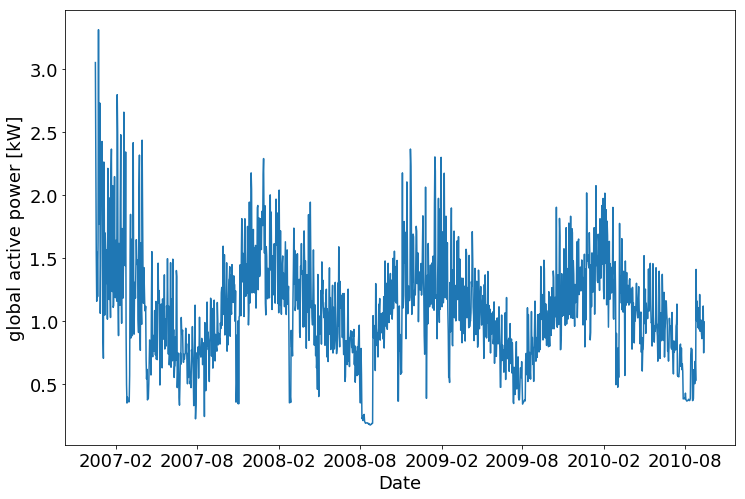

In [117]:
x = pd.Series(map(lambda x: pd.Timestamp(x), df.index))
y = df['Global_active_power']
data = pd.DataFrame(y, index=x)

size = 0.95
idx = int(size*len(x))
x_train = x[:idx]
x_test = x[idx:]
y_train = y[:idx]
y_test = y[idx:]

fig = plt.figure(figsize=(12,8));
plt.plot(x_train,y_train);
#ax = data.plot();
plt.xlabel('Date');
plt.ylabel('global active power [kW]');


# Forecasting

## 1. Simple forecasts

First of all we try three simple forecasting models. The red line forecast corresponds to a model, where all future values are predicted by the mean of the training data. The black line corresponds to a forecast, where all future values are equal to the last value of the time series.
The orange line shows a naive seasonal forecast. Here, we predict the value from the previous year as a forecast. The green line shows the true data (test set).

In [118]:
mean = pd.Series([y_train.mean() for _ in range(len(x_test))])
naive = pd.Series([y_train[-1] for _ in range(len(x_test))])
season_naive = pd.Series([y_train[-365+n] for n in range(len(x_test))])

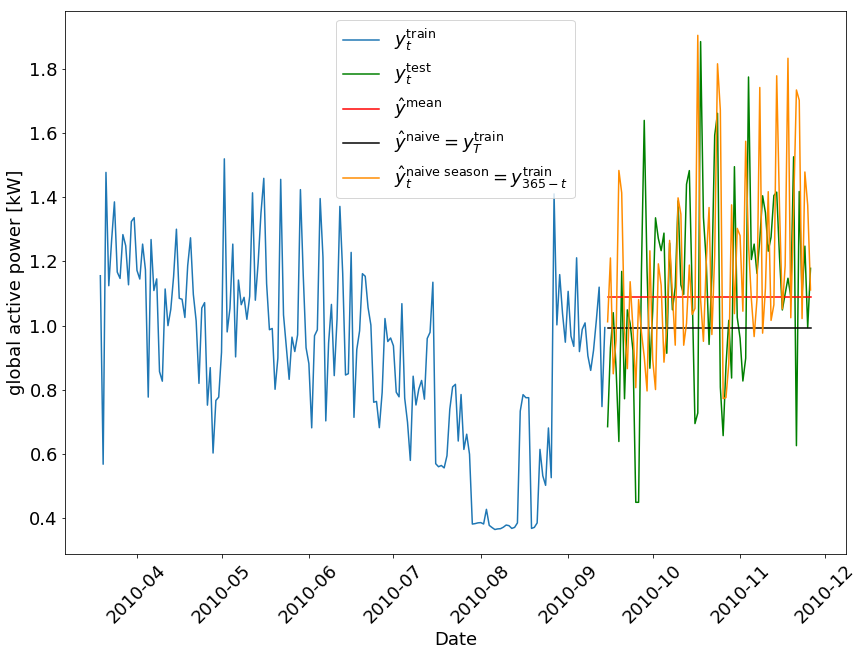

In [119]:
fig = plt.figure(figsize=(14,10))
plt.plot(x_train[-180:],y_train[-180:], label='$y^\\mathrm{train}_t$');
plt.plot(x_test, y_test, 'g-', label='$y^\\mathrm{test}_{t}$');
plt.xlabel('Date');
plt.ylabel('global active power [kW]');

plt.plot(x_test, mean, 'r-', label="$\\hat{y}^\\mathrm{mean}$");
plt.plot(x_test, naive, 'k-', label="$\\hat{y}^\\mathrm{naive} = y^\\mathrm{train}_T$");
plt.plot(x_test, season_naive, c='darkorange', ls='-', label="$\\hat{y}^\\mathrm{naive\ season}_t = y^\\mathrm{train}_{365-t}$");
plt.legend(loc='best');
for item in plt.gca().xaxis.get_ticklabels():
    item.set_rotation(45)

In order to evaluate the performance of the three models we calculate the residuals for each. They are given by $e_t = y_t - \hat{y}_t$, where $y_t$ is the true value of the test set and $\hat{y}_t$ is our prediction at time $t$.

A good performance is usually assumed, when the residuals
- are uncorrelated
- have zero mean

Furthermore, it is useful that the residuals
- have constant variance
- are normally distributed

See https://otexts.com/fpp2/residuals.html

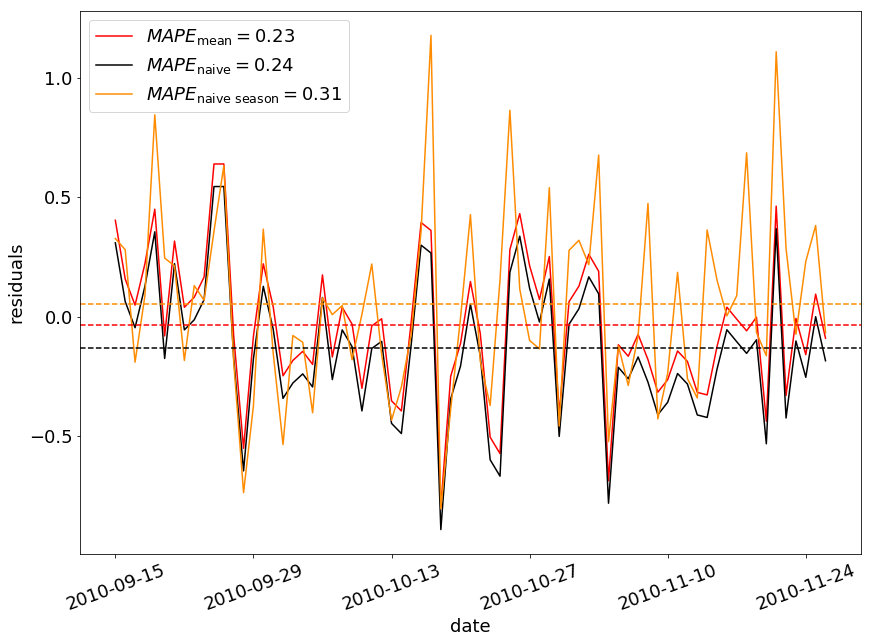

In [120]:
residual_mean = (np.array(mean)-np.array(y_test))
residual_naive = (np.array(naive)-np.array(y_test))
residual_season_naive = (np.array(season_naive)-np.array(y_test))

mape_mean = MAPE(np.array(mean), np.array(y_test))
mape_naive = MAPE(np.array(naive), np.array(y_test))
mape_season_naive = MAPE(np.array(season_naive), np.array(y_test))

fig = plt.figure(figsize=(14,10))

plt.plot(x_test, residual_mean, 'r-', label="$MAPE_\\mathrm{mean} = $" + "{0:.2f}".format(mape_mean));
plt.plot(x_test, residual_naive, 'k-', label="$MAPE_\\mathrm{naive} = $" + "{0:.2f}".format(mape_naive));
plt.plot(x_test, residual_season_naive, c='darkorange', ls='-', label="$MAPE_\\mathrm{naive\ season} = $" + "{0:.2f}".format(mape_season_naive));

plt.axhline(np.mean(residual_mean), c='r', ls='--');
plt.axhline(np.mean(residual_naive), c='k', ls='--');
plt.axhline(np.mean(residual_season_naive), c='darkorange', ls='--');

plt.legend(loc='best');
plt.xlabel('date');
plt.ylabel('residuals');
for item in plt.gca().xaxis.get_ticklabels():
    item.set_rotation(20)


We see that the naive and the mean method have a smaller MAPE error than the naive seasonal forecast. However, the residuals do not have a vanishing mean.

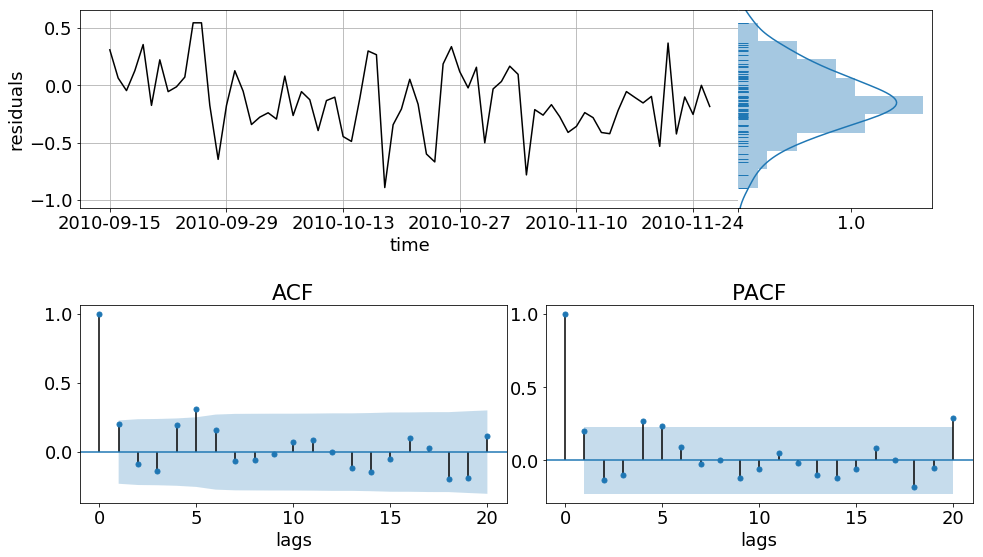

In [121]:
plot_ACF(x_test, residual_naive)

When looking at the naive forecast, we see in the ACF plot that there are still correlations between the residuals, emphasizing that our model can be improved.

In [122]:
ljung_box_test(residual_naive)

Estimated required lag to be h= 10
Ljung-Box test
 Number of p-values below significance level of 0.05: 6
Box-Pierce test
 Number of p-values below significance level of 0.05: 5
When there are p-values below the significance level, we can reject the null hypothesis, meaning that there are still correlations in the data. 


#### Ljung-Box test:

Null hypothesis $H_0$: 

data ist independently distributed, the correlations in the population from which the sample is taken are $0$, meaning that any observed correlations in the data result from randomness in the sampling process (https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test)

$p<\alpha$: reject $H_0$, meaning there are still correlations in the data thus it is not stationary


## 2. Decompositions: Moving averages

As a next step we compute moving averages of the time series data to get a smoother functionality.
Firstly, we compute moving averages by averaging over one week, one month, half a year and a whole year. As the averaging interval gets larger, the averaged time series gets smoother. However, when averaging over a whole year it seems that there is some information washed out, because we get a straight line.

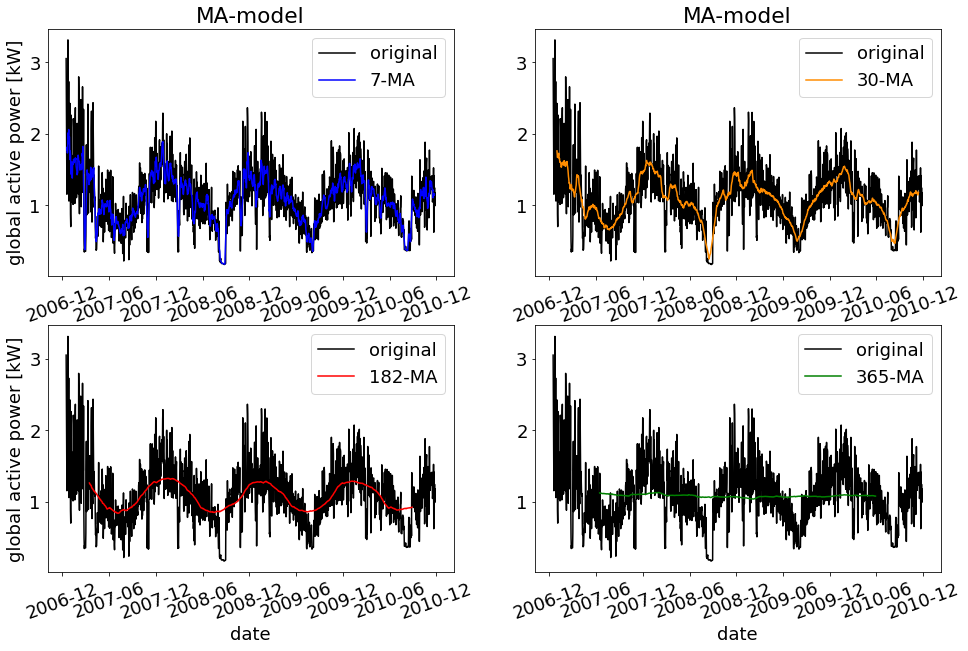

In [123]:
m2 = data.rolling(window=2, center=True).mean()
m7 = data.rolling(window=7, center=True).mean()
m30 = data.rolling(window=30, center=True).mean()
m182 = data.rolling(window=182, center=True).mean()
m365 = data.rolling(window=365, center=True).mean()

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(2,2,1)
ax.plot(data.index, data['Global_active_power'], c='k', label="original");
ax.plot(m7.index, m7['Global_active_power'], c='b', label="7-MA");
ax.legend(loc='best');
ax.set_ylabel("global active power [kW]");
ax.set_title("MA-model");



ax1 = fig.add_subplot(2,2,2)
ax1.plot(data.index, data['Global_active_power'], c='k', label="original");
ax1.plot(m30.index, m30['Global_active_power'], c='darkorange', label="30-MA");
ax1.legend(loc='best');
ax1.set_title("MA-model");


ax2 = fig.add_subplot(2,2,3)
ax2.plot(data.index, data['Global_active_power'], c='k', label="original");
ax2.plot(m182.index, m182['Global_active_power'], c='red', label="182-MA");
ax2.legend(loc='best');
ax2.set_xlabel("date");
ax2.set_ylabel("global active power [kW]");


ax3 = fig.add_subplot(2,2,4)
ax3.plot(data.index, data['Global_active_power'], c='k', label="original");
ax3.plot(m365.index, m365['Global_active_power'], c='green', label="365-MA");
ax3.legend(loc='best');
ax3.set_xlabel("date");

for axes in [ax, ax1, ax2, ax3]:
    for item in axes.xaxis.get_ticklabels():
        item.set_rotation(20)





In order to improve the moving average model, we apply a weighted moving average model. Here, we use a Hamming window and weigh data points according to that window. This gives improved results.

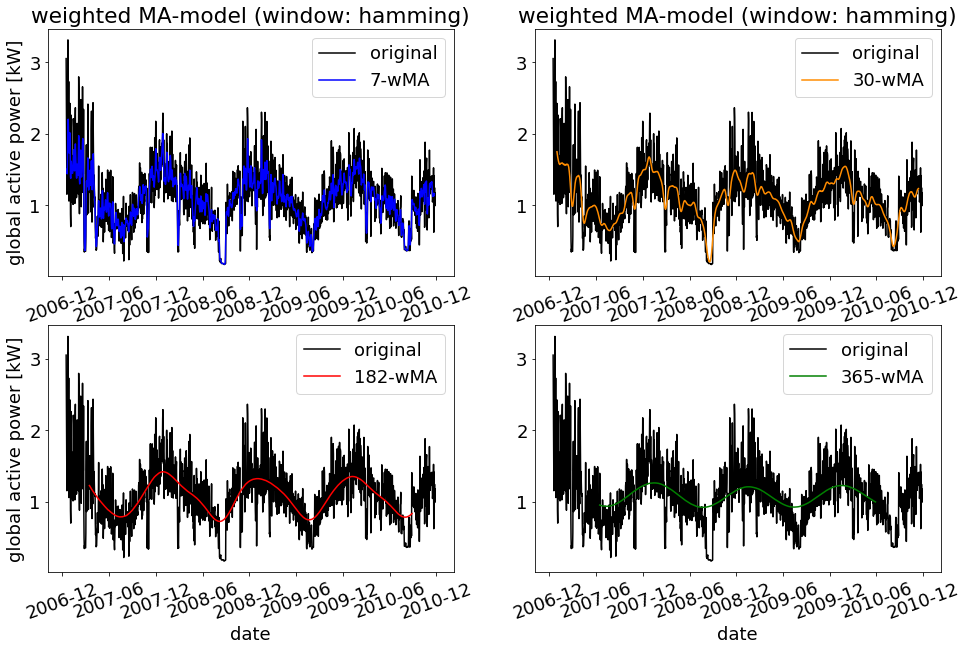

In [124]:
my_windowtype = 'hamming'

m2 = data.rolling(window=2, center=True, win_type=my_windowtype).mean()
m7 = data.rolling(window=7, center=True, win_type=my_windowtype).mean()
m30 = data.rolling(window=30, center=True , win_type=my_windowtype).mean()
m182 = data.rolling(window=182, center=True, win_type=my_windowtype).mean()
m365 = data.rolling(window=365, center=True, win_type=my_windowtype).mean()

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(2,2,1)
ax.plot(data.index, data['Global_active_power'], c='k', label="original");
ax.plot(m7.index, m7['Global_active_power'], c='b', label="7-wMA");
ax.legend(loc='best');
ax.set_ylabel("global active power [kW]");
ax.set_title("weighted MA-model (window: {0})".format(my_windowtype));


ax1 = fig.add_subplot(2,2,2)
ax1.plot(data.index, data['Global_active_power'], c='k', label="original");
ax1.plot(m30.index, m30['Global_active_power'], c='darkorange', label="30-wMA");
ax1.legend(loc='best');
ax1.set_title("weighted MA-model (window: {0})".format(my_windowtype));


ax2 = fig.add_subplot(2,2,3)
ax2.plot(data.index, data['Global_active_power'], c='k', label="original");
ax2.plot(m182.index, m182['Global_active_power'], c='red', label="182-wMA");
ax2.legend(loc='best');
ax2.set_xlabel("date");
ax2.set_ylabel("global active power [kW]");


ax3 = fig.add_subplot(2,2,4)
ax3.plot(data.index, data['Global_active_power'], c='k', label="original");
ax3.plot(m365.index, m365['Global_active_power'], c='green', label="365-wMA");
ax3.legend(loc='best');
ax3.set_xlabel("date");

for axes in [ax, ax1, ax2, ax3]:
    for item in axes.xaxis.get_ticklabels():
        item.set_rotation(20)

In the following panel we use a classical decomposition of the time series, such that we get a seasonal component as well as a trend-cycle component and the remainder. This is automatically calculated using moving averages.

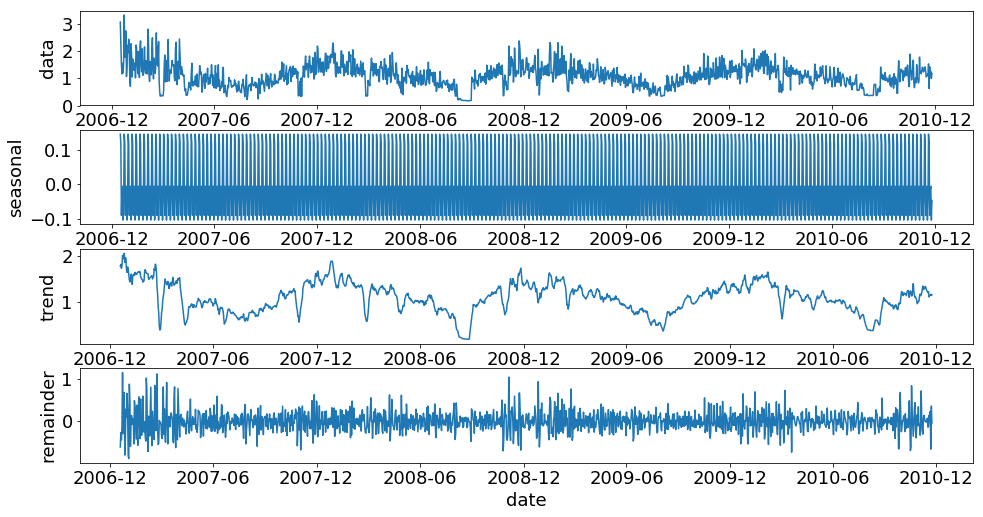

In [125]:
plot_decomposition(data, model='additive')

In [126]:
F_trend = measure_trend(data)
F_season = measure_seasonality(data)
print("Strengths of trend and seasonality")
print("Additive model: trend={0:.3f}, \t seasonality={1:.3f}".format(F_trend[0], F_season[0]))
print("Multiplicative model: trend={0:.3f}, \t seasonality={1:.3f}".format(F_trend[1], F_season[1]))

Strengths of trend and seasonality
Additive model: trend=0.644, 	 seasonality=0.119
Multiplicative model: trend=0.696, 	 seasonality=0.100


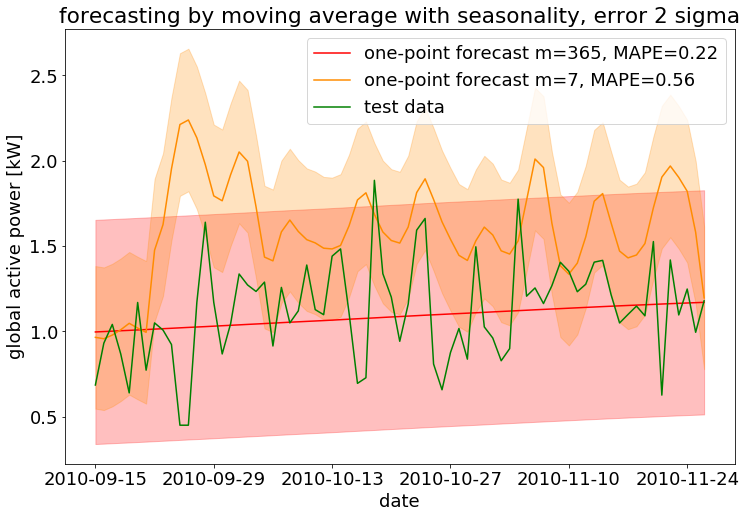

In [127]:
train = pd.DataFrame(y_train, index=x_train)
test = pd.DataFrame(y_test, index=x_test)
(pred, obs, std) = forecast_movingaverage(train, test, seasonal=365)
(pred1, obs1, std1) = forecast_movingaverage(train, test, seasonal=7)

mape = MAPE(pred, obs)
mape1 = MAPE(pred1, obs1)

sigmas = 2

fig = plt.figure(figsize=(12,8))

plt.plot(pred.index, pred.values, 'r', label="one-point forecast m=365, MAPE={0:.2f}".format(mape));
plt.fill_between(np.array(pred.index), np.array(pred.values.reshape(-1,)-sigmas*std), np.array(pred.values.reshape(-1,)+sigmas*std), \
                 color='r', alpha=0.25);

plt.plot(pred1.index, pred1['Global_active_power'], 'darkorange', label="one-point forecast m=7, MAPE={0:.2f}".format(mape1));
plt.fill_between(np.array(pred1.index), np.array(pred1.values.reshape(-1,)-sigmas*std1), np.array(pred1.values.reshape(-1,)+sigmas*std1),\
                 color='darkorange', alpha=0.25);

plt.plot(obs.index, obs['Global_active_power'], 'g', label="test data");
plt.xlabel("date");
plt.ylabel("global active power [kW]");
plt.title("forecasting by moving average with seasonality, error {0} sigma".format(sigmas))
plt.legend(loc='best');

## 3. Decompositions: Holt-Winters Exponential Smoothing

As a further improvement, we look at exponential smoothing. Here, the weight of older data points decreases exponentially and they have far less influence on a future forecast than the most recent data points. We do not consider the trend option, because the data shows no trend behaviour and try different seasonal periods. The error is already much smaller than with the moving average method. However, the naive and mean methods from above have an error of the same size.

In [128]:
m = 7
m2 = 182

model = ExponentialSmoothing(train, trend=None, damped=False, seasonal='add', dates=train.index, seasonal_periods=m)
fit = model.fit()
# pred = fit.forecast(len(test))

model2 = ExponentialSmoothing(train, trend=None, damped=False, seasonal='add', dates=train.index, seasonal_periods=m2)
fit2 = model2.fit()
# pred2 = fit2.forecast(len(test))

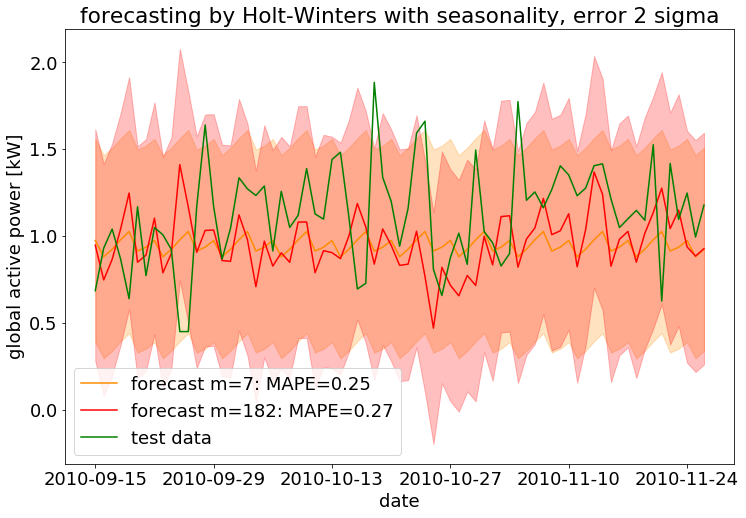

In [129]:
pred = fit.forecast(len(test))
pred2 = fit2.forecast(len(test))

mape = MAPE(pred.values, test.values)
mape2 = MAPE(pred2.values, test.values)

std = float(np.std(pred.values - test.values))
std2 = float(np.std(pred2.values - test.values))

sigmas = 2

fig = plt.figure(figsize=(12,8))

plt.plot(test.index, pred.values, 'darkorange', label="forecast m={1}: MAPE={0:.2f}".format(mape, m));
plt.fill_between(np.array(pred.index), np.array(pred.values.reshape(-1,)-sigmas*std), \
                 np.array(pred.values.reshape(-1,)+sigmas*std), color='darkorange', alpha=0.25);

plt.plot(test.index, pred2.values, 'red', label="forecast m={1}: MAPE={0:.2f}".format(mape2, m2));
plt.fill_between(np.array(pred2.index), np.array(pred2.values.reshape(-1,)-sigmas*std2), \
                 np.array(pred2.values.reshape(-1,)+sigmas*std2), color='red', alpha=0.25);

plt.plot(test.index, test.values, 'g', label="test data");
plt.xlabel("date");
plt.ylabel("global active power [kW]");
plt.title("forecasting by Holt-Winters with seasonality, error {0} sigma".format(sigmas))
plt.legend(loc='best');